The work presented in this notebook is based on the paper:

`A fast quantum mechanical algorithm for database search` https://doi.org/10.1145/237814.237866 .

# Imports

In [1]:
# To install Qiskit, uncomment and run the line below
# !pip install -r requirements.txt --quiet

# If you haven't used your IBMQ account yet, load it using your TOKEN:
# IBMQ.save_account(TOKEN)

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
import qiskit.tools.jupyter

# Provider and backends

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')
backend_qc = provider.get_backend('ibmq_manila')
backend_qc_sim = QasmSimulator.from_backend(backend_qc)

# Standard Grover Algorithm (SGA)

We will build two versions of SGA, with and without ancillary qubits. For simplicity reasons, we'll make a 2-qubit search example and choose the state |11> as the desired state, i.e. the state for which the oracle function returns 1.

To make clear what the individual parts of the algorithm are, we'll build them individually and then compose the final circuit.

## Version with 1 ancillary qubit

First, we build the `init` circuit, which initializes the system before applying successive iterations of the Grover operator.

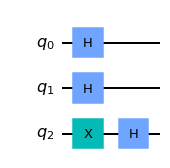

In [4]:
init = QuantumCircuit(3)
init.h([0, 1])
init.x(2)
init.h(2)
init.draw()

Secondly, we build the `oracle` circuit, that flips the sign of a basis state |x> if it is a solution to the search problem, i.e. if f(x) = 1. In this case the solution is |11>, so the oracle has the following form:

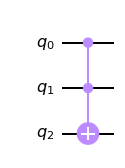

In [5]:
oracle = QuantumCircuit(3)
oracle.ccx(0, 1, 2)
oracle.draw()

Thirdly, we build the `diffusion` operator.

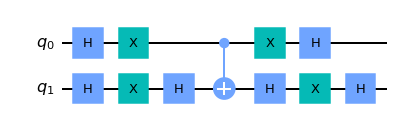

In [6]:
diffusion = QuantumCircuit(2)
diffusion.h([0, 1])
diffusion.x([0, 1])
diffusion.h(1)
diffusion.cx(0, 1)
diffusion.h(1)
diffusion.x([0, 1])
diffusion.h([0, 1])
diffusion.draw()

Now let's assemble the `grover` operator, which consists of applying the oracle and then the difussion.

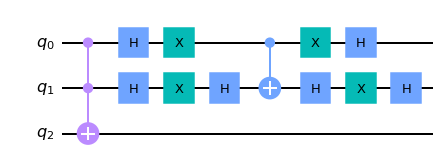

In [7]:
grover = QuantumCircuit(3)
grover.compose(oracle, inplace=True)
grover.compose(diffusion, inplace=True)
grover.draw()

Finally we can build a list of circuits, where the $i$th circuit has $i$ grover iterations.

In [8]:
circ_lst = []

qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(2, 'c')
circ = QuantumCircuit(qr, cr)

circ.compose(init, inplace=True)
circ_temp = deepcopy(circ)
circ_temp.barrier()
circ_temp.measure(qr[:2], cr)
circ_lst.append(circ_temp)

for i in range(10):
    circ.compose(grover, inplace=True)
    circ_temp = deepcopy(circ)
    circ_temp.barrier()
    circ_temp.measure(qr[:2], cr)
    circ_lst.append(circ_temp)

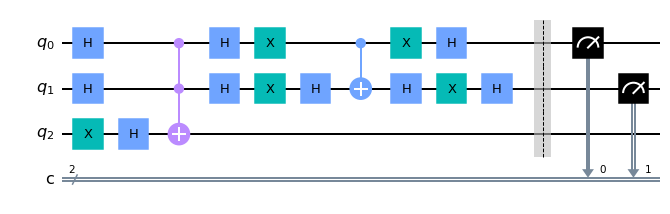

In [9]:
circ_lst[1].draw()

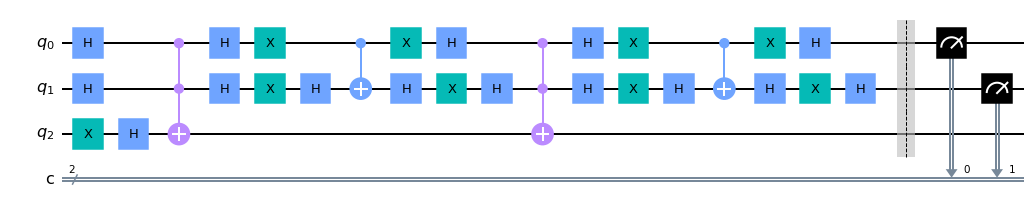

In [10]:
circ_lst[2].draw()

Run the circuits and store probability of measuring '11' state.

In [11]:
job = execute(circ_lst, backend=backend_sim, shots=20000)

def success_probabilities(counts):
    probs = []
    for c in counts:
        probs.append(c.get('11', 0)/20000)
    return probs

success_probs = success_probabilities(job.result().get_counts())
print(success_probs)

[0.2478, 1.0, 0.2476, 0.2522, 1.0, 0.25315, 0.25035, 1.0, 0.2467, 0.2516, 1.0]


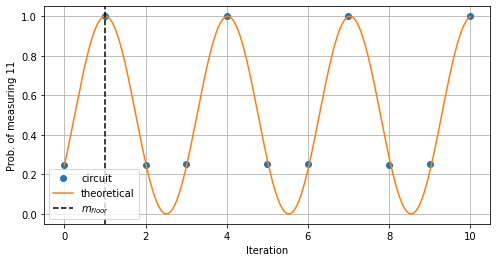

In [12]:
def plot_probs(probs):
    a = probs[0]
    theta = np.arcsin(np.sqrt(a))
    m = np.arange(len(probs))
    ms = np.linspace(m[0], m[-1], 1000)
    
    plt.figure(figsize=(8, 4))
    plt.xlabel('Iteration')
    plt.ylabel('Prob. of measuring 11')
    plt.plot(success_probs, 'o', label='circuit')
    plt.plot(ms, np.sin((2*ms+1)*theta)**2, label='theoretical')
    plt.axvline(x=np.floor(np.pi/(4*theta)), c='k', ls='--', label=r'$m_{floor}$')
    plt.legend()
    plt.grid()
    plt.show()
    
plot_probs(success_probs)

We see that in our case only one iteration of the `grover` operator is necessary, because it already yiels probability 1 of finding our desired state. However, this was run in a simulator, let's run this in an actual quantum computer.

In [13]:
# job = execute(circ_lst, backend=backend_qc, shots=20000) #61ca082a3b5b842271103580
# job_monitor(job)
job = backend_qc.retrieve_job('61ca082a3b5b842271103580')

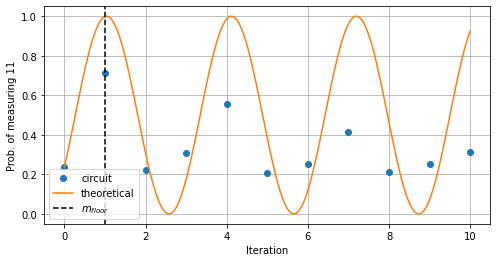

In [14]:
success_probs = success_probabilities(job.result().get_counts())
plot_probs(success_probs)

Because an actual quantum computer suffers from noise errors, it's behaviour is not the same as the simulator. To start, the probability of measuring '11' is peaks at 0.7 after one iteration, instead of 1, and then decays.

## Version with no ancillary qubits

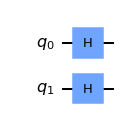

In [15]:
new_init = QuantumCircuit(2)
new_init.h([0, 1])
new_init.draw()

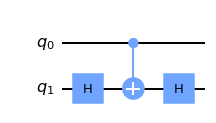

In [16]:
new_oracle = QuantumCircuit(2)
new_oracle.h(1)
new_oracle.cx(0, 1)
new_oracle.h(1)
new_oracle.draw()

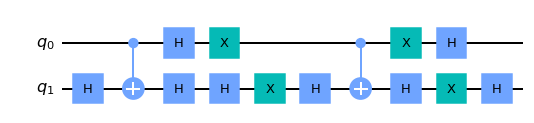

In [17]:
new_grover = QuantumCircuit(2)
new_grover.compose(new_oracle, inplace=True)
new_grover.compose(diffusion, inplace=True)
new_grover.draw()

In [18]:
circ_lst = []

qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')
circ = QuantumCircuit(qr, cr)

circ.compose(new_init, inplace=True)
circ_temp = deepcopy(circ)
circ_temp.barrier()
circ_temp.measure(qr[:2], cr)
circ_lst.append(circ_temp)

for i in range(10):
    circ.compose(new_grover, inplace=True)
    circ_temp = deepcopy(circ)
    circ_temp.barrier()
    circ_temp.measure(qr[:2], cr)
    circ_lst.append(circ_temp)

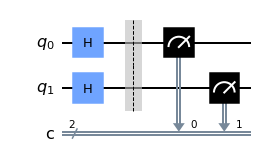

In [19]:
circ_lst[0].draw()

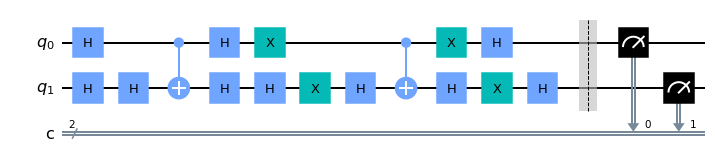

In [20]:
circ_lst[1].draw()

[0.2477, 1.0, 0.25285, 0.24895, 1.0, 0.2531, 0.25285, 1.0, 0.2497, 0.2541, 1.0]


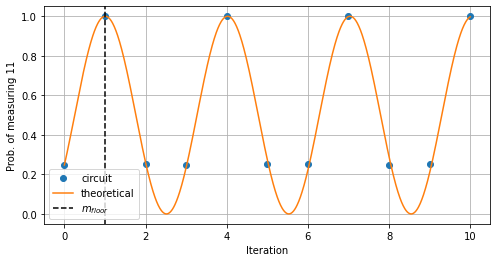

In [21]:
job = execute(circ_lst, backend=backend_sim, shots=20000)
success_probs = success_probabilities(job.result().get_counts())
print(success_probs)
plot_probs(success_probs)

In [22]:
# job = execute(circ_lst, backend=backend_qc, shots=20000) #61cc851d063519e7b6a7f36f
# job = execute(circ_lst, backend=backend_qc_sim, shots=20000)
# print(job.job_id())
# job_monitor(job)
# job = backend_qc.retrieve_job('61ca082a3b5b842271103580')

[0.2237, 0.92825, 0.25545, 0.22285, 0.90045, 0.2641, 0.2276, 0.88275, 0.2563, 0.2311, 0.8679]


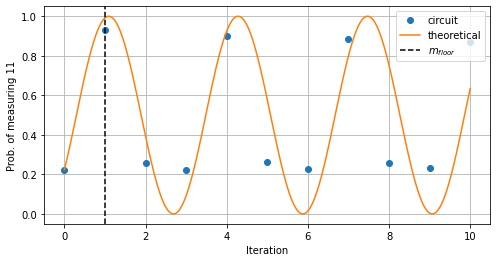

In [24]:
job = backend_qc.retrieve_job('61cc851d063519e7b6a7f36f')
success_probs = success_probabilities(job.result().get_counts())
print(success_probs)
plot_probs(success_probs)

The fact that used a standard CNOT gate instead of the Toffoli gate (CCNOT) is the reason why the results are much better than the ancillary case.

In [ ]:
%qiskit_version_table